# Problem: Predicting Airplane Delays

The goals of this notebook are:
- Process and create a dataset from downloaded ZIP files
- Exploratory data analysis (EDA)
- Establish a baseline model and improve it

## Introduction to business scenario
You work for a travel booking website that is working to improve the customer experience for flights that were delayed. The company wants to create a feature to let customers know if the flight will be delayed due to weather when the customers are booking the flight to or from the busiest airports for domestic travel in the US. 

You are tasked with solving part of this problem by leveraging machine learning to identify whether the flight will be delayed due to weather. You have been given access to the a dataset of on-time performance of domestic flights operated by large air carriers. You can use this data to train a machine learning model to predict if the flight is going to be delayed for the busiest airports.

### Dataset
The provided dataset contains scheduled and actual departure and arrival times reported by certified US air carriers that account for at least 1 percent of domestic scheduled passenger revenues. The data was collected by the Office of Airline Information, Bureau of Transportation Statistics (BTS). The dataset contains date, time, origin, destination, airline, distance, and delay status of flights for flights between 2014 and 2018.
The data are in 60 compressed files, where each file contains a CSV for the flight details in a month for the five years (from 2014 - 2018). The data can be downloaded from this link: [https://ucstaff-my.sharepoint.com/:f:/g/personal/ibrahim_radwan_canberra_edu_au/Er0nVreXmihEmtMz5qC5kVIB81-ugSusExPYdcyQTglfLg?e=bNO312]. Please download the data files and place them on a relative path. Dataset(s) used in this assignment were compiled by the Office of Airline Information, Bureau of Transportation Statistics (BTS), Airline On-Time Performance Data, available with the following link: [https://www.transtats.bts.gov/Fields.asp?gnoyr_VQ=FGJ]. 

# Step 1: Prepare the environment 

Use one of the labs which we have practised on with the Amazon Sagemakers where you perform the following steps:
1. Start a lab.
2. Create a notebook instance and name it "oncloudproject".
3. Increase the used memory to 25 GB from the additional configurations.
4. Open Jupyter Lab and upload this notebook into it.
5. Upload the two combined CVS files (combined_csv_v1.csv and combined_csv_v2.csv), which you created in Part A of this project.

# Step 2: Build and evaluate simple models

Write code to perform the follwoing steps:
1. Split data into training, validation and testing sets (70% - 15% - 15%).
2. Use linear learner estimator to build a classifcation model.
3. Host the model on another instance
4. Perform batch transform to evaluate the model on testing data
5. Report the performance metrics that you see better test the model performance 

Note: You are required to perform the above steps on the two combined datasets separatey and to comments on the difference.

In [1]:
!pip show sagemaker

Name: sagemaker
Version: 2.188.0
Summary: Open source library for training and deploying models on Amazon SageMaker.
Home-page: https://github.com/aws/sagemaker-python-sdk/
Author: Amazon Web Services
Author-email: 
License: Apache License 2.0
Location: /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages
Requires: attrs, boto3, cloudpickle, google-pasta, importlib-metadata, jsonschema, numpy, packaging, pandas, pathos, platformdirs, protobuf, PyYAML, schema, smdebug-rulesconfig, tblib
Required-by: 


In [118]:
import warnings, requests, zipfile, io
import pandas as pd
warnings.simplefilter('ignore')
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.model import Model
from sagemaker import LinearLearner
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer
from sagemaker.deserializers import CSVDeserializer
from sagemaker.image_uris import retrieve
from sagemaker.estimator import Estimator

#sklearn libraries
from sklearn.model_selection import train_test_split
import numpy as np
from time import strftime, gmtime
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [35]:
s3 = boto3.client("s3")

In [42]:
# read the csvs
data1 = pd.read_csv('combined_csv_v1.csv')
data2 = pd.read_csv('combined_csv_v2.csv')

In [43]:
# Step 1: Check for unique strings in object columns
object_cols = data1.select_dtypes(include=['object']).columns
unique_values = {col: data1[col].unique() for col in object_cols}
print(unique_values)  # This will show you all unique string values in the object columns

# Step 2: Replace known boolean strings and anomalies
data1.replace({'True': 1.0, 'False': 0.0, 'Fals': 0.0}, inplace=True)

# Convert any remaining object columns to float64
data1[object_cols] = data1[object_cols].astype('float64')


{'Quarter_3': array([False, True, nan], dtype=object), 'Quarter_4': array([False, True, nan], dtype=object), 'Month_2': array([False, True, nan], dtype=object), 'Month_3': array([False, True, nan], dtype=object), 'Month_4': array([False, True, nan], dtype=object), 'Month_5': array([False, True, nan], dtype=object), 'Month_6': array([False, True, nan], dtype=object), 'Month_7': array([False, True, nan], dtype=object), 'Month_8': array([False, True, nan], dtype=object), 'Month_9': array([False, True, nan], dtype=object), 'Month_10': array([False, True, nan], dtype=object), 'Month_11': array([False, True, nan], dtype=object), 'Month_12': array([False, True, nan], dtype=object), 'DayofMonth_2': array([False, True, nan], dtype=object), 'DayofMonth_3': array([False, True, nan], dtype=object), 'DayofMonth_4': array([False, True, nan], dtype=object), 'DayofMonth_5': array([False, True, nan], dtype=object), 'DayofMonth_6': array([False, True, nan], dtype=object), 'DayofMonth_7': array([False, T

In [45]:
data1.dropna(inplace=True)

In [38]:
#clean the data1
bool_cols = [col for col in data1.columns if data1[col].dtype == np.bool]
data1[bool_cols] = data1[bool_cols].astype('float64')


In [46]:
# Convert any remaining object columns to float64
#object_cols = data1.select_dtypes(include=['object']).columns
#data1[object_cols] = data1[object_cols].astype('float64')

In [47]:
data1.head(2)

target  Distance  DepHourofDay  Quarter_2  Quarter_3  Quarter_4  Month_2  \
0     0.0     689.0            24      False        0.0        0.0      0.0   
1     0.0     731.0            12      False        0.0        0.0      0.0   

   Month_3  Month_4  Month_5  ...  Origin_PHX  Origin_SFO  Dest_CLT  Dest_DEN  \
0      0.0      0.0      0.0  ...         0.0         0.0       0.0       0.0   
1      0.0      0.0      0.0  ...         0.0         0.0       0.0       0.0   

   Dest_DFW  Dest_IAH  Dest_LAX  Dest_ORD  Dest_PHX  Dest_SFO  
0       0.0       1.0       0.0       0.0       0.0       0.0  
1       0.0       0.0       0.0       0.0       0.0       0.0  

[2 rows x 73 columns]

### 1.Split data into training, validation and testing sets (70% - 15% - 15%).

In [48]:
train_validation_data1, test_data1 = train_test_split(data1, test_size=0.15, random_state=14)

train_data1, validation_data1 = train_test_split(train_validation_data1, test_size=0.1765, random_state=14) # 0.1765 * 0.85 = 0.15

train_y1 = train_data1.iloc[:, 0].to_numpy()
train_X1 = train_data1.iloc[:, 1:].to_numpy()

validation_y1 = validation_data1.iloc[:, 0].to_numpy()
validation_X1 = validation_data1.iloc[:, 1:].to_numpy()

test_y1 = test_data1.iloc[:, 0].to_numpy()
test_X1 = test_data1.iloc[:, 1:].to_numpy()

In [49]:
print(train_data1.shape)
print(validation_data1.shape)

(377082, 73)
(80820, 73)


In [50]:
train_data1.to_csv('train_data1.csv', index=False, header=False)
validation_data1.to_csv('validation_data1.csv', index=False, header=False)
test_data1.to_csv('test_data1.csv', index=False, header=False)

In [51]:
s3_session = sagemaker.Session()
bucket = s3_session.default_bucket()
bucket

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


'sagemaker-us-east-1-057243345877'

In [52]:
train_data1_s3_path = 'data1/train_data1.csv'
validation_data1_s3_path = 'data1/validation_data1.csv'
test_data1_s3_path = 'data1/test_data1.csv'

s3_client = boto3.client('s3')
s3_client.upload_file('train_data1.csv', bucket, train_data1_s3_path)
s3_client.upload_file('validation_data1.csv', bucket, validation_data1_s3_path)
s3_client.upload_file('test_data1.csv', bucket, test_data1_s3_path)

response = s3_client.list_objects(Bucket=bucket, Prefix='data1/')
for item in response.get('Contents', []):
    print(f's3://{bucket}/{item["Key"]}')

s3://sagemaker-us-east-1-057243345877/data1/test_data1.csv
s3://sagemaker-us-east-1-057243345877/data1/train_data1.csv
s3://sagemaker-us-east-1-057243345877/data1/validation_data1.csv


### My first training job failed because of empty data... deal with data

In [53]:
df_train1 = pd.read_csv('train_data1.csv')
df_validation1 = pd.read_csv('validation_data1.csv')
df_test1 = pd.read_csv('test_data1.csv')

In [54]:
if df_train1.isnull().any().any():
    print("df_train1 contains empty values.")
else:
    print("df_train1 does not contain any empty values.")

if df_validation1.isnull().any().any():
    print("df_validation1 contains empty values.")
else:
    print("df_validation1 does not contain any empty values.")
    
if df_test1.isnull().any().any():
    print("df_test1 contains empty values.")
else:
    print("df_test1 does not contain any empty values.")


df_train1 does not contain any empty values.
df_validation1 does not contain any empty values.
df_test1 does not contain any empty values.


In [55]:
### Dealted with in early step now
#df_train1 .fillna(df_train1.mean(), inplace=True)
#df_train1 .to_csv('train_data1.csv', index=False)

In [56]:
#df_train1 = pd.read_csv('train_data1.csv')
#df_train1.isnull().any().any()

In [57]:
#s3_client.upload_file('train_data1.csv', bucket, train_data1_s3_path)

### 2. Use linear learner estimator to build a classifcation model.

In [58]:
role = get_execution_role()
region = boto3.Session().region_name
container = get_image_uri(region, 'linear-learner')

ll_estimator = Estimator(container,
    role=role, 
    train_instance_count=1,
    train_instance_type='ml.m5.2xlarge',
    output_path=f's3://{bucket}/output',
)
ll_estimator.set_hyperparameters(predictor_type='binary_classifier', mini_batch_size=100)


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [ ]:
s3_train_data = TrainingInput(s3_data=f's3://{bucket}/{train_data1_s3_path}', content_type='text/csv')
s3_validation_data = TrainingInput(s3_data=f's3://{bucket}/{validation_data1_s3_path}', content_type='text/csv')

data_channels = {
    'train': s3_train_data,
    'validation': s3_validation_data
}

ll_estimator.fit(data_channels, wait=True)


INFO:sagemaker:Creating training-job with name: linear-learner-2023-10-28-12-43-19-093


2023-10-28 12:43:19 Starting - Starting the training job...
2023-10-28 12:43:35 Starting - Preparing the instances for training......
2023-10-28 12:44:28 Downloading - Downloading input data...
2023-10-28 12:44:53 Training - Downloading the training image...
2023-10-28 12:45:43 Training - Training image download completed. Training in progress....Docker entrypoint called with argument(s): train
Running default environment configuration script
[10/28/2023 12:46:08 INFO 140103139505984] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss': 'a

### 3. Host the model on another instance

In [60]:
response = s3_client.list_objects_v2(Bucket=bucket, Prefix=ll_estimator.output_path.split('/')[-1])
for content in response.get('Contents', []):
    print(content['Key'])

output/linear-learner-2023-10-28-12-27-19-157/debug-output/training_job_end.ts
output/linear-learner-2023-10-28-12-27-19-157/profiler-output/framework/training_job_end.ts
output/linear-learner-2023-10-28-12-27-19-157/profiler-output/system/incremental/2023102812/1698496080.algo-1.json
output/linear-learner-2023-10-28-12-27-19-157/profiler-output/system/incremental/2023102812/1698496140.algo-1.json
output/linear-learner-2023-10-28-12-27-19-157/profiler-output/system/incremental/2023102812/1698496200.algo-1.json
output/linear-learner-2023-10-28-12-27-19-157/profiler-output/system/training_job_end.ts
output/linear-learner-2023-10-28-12-43-19-093/debug-output/training_job_end.ts
output/linear-learner-2023-10-28-12-43-19-093/output/model.tar.gz
output/linear-learner-2023-10-28-12-43-19-093/profiler-output/framework/training_job_end.ts
output/linear-learner-2023-10-28-12-43-19-093/profiler-output/system/incremental/2023102812/1698497040.algo-1.json
output/linear-learner-2023-10-28-12-43-19-0

In [63]:
timestamp = strftime('%d-%H-%M-%S', gmtime())
endpoint_name = 'linear-learner-1-' + timestamp
print(endpoint_name)

linear-learner-1-28-13-17-32


In [64]:
ll_predictor = ll_estimator.deploy(endpoint_name=endpoint_name, 
                                   initial_instance_count=1, 
                                   instance_type='ml.m5.2xlarge')

INFO:sagemaker:Creating model with name: linear-learner-2023-10-28-13-17-36-592
INFO:sagemaker:Creating endpoint-config with name linear-learner-1-28-13-17-32
INFO:sagemaker:Creating endpoint with name linear-learner-1-28-13-17-32


------!

In [276]:
df_test1 = pd.read_csv('test_data.csv')

In [277]:
actual_list = df_test1[df_test1.columns[0]].tolist()

In [278]:
df_test1.drop('0.0', axis=1, inplace=True)

In [316]:
# Configure the predictor
ll_predictor.content_type = 'text/csv'
ll_predictor.serializer = CSVSerializer()  # Note the parentheses to create an instance
ll_predictor.deserializer = CSVDeserializer()

predictions = ll_predictor.predict(df_test1.head(20000))

## Evaluation on model 1


In [317]:
predicted_values = [float(pred[0]) for pred in predictions]
actual_values = actual_list[:20000]

accuracy = accuracy_score(actual_values, predicted_values)
precision = precision_score(actual_values, predicted_values)
recall = recall_score(actual_values, predicted_values)
f1 = f1_score(actual_values, predicted_values)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.76075
Precision: 0.5
Recall: 0.0006269592476489029
F1 Score: 0.0012523481527864748


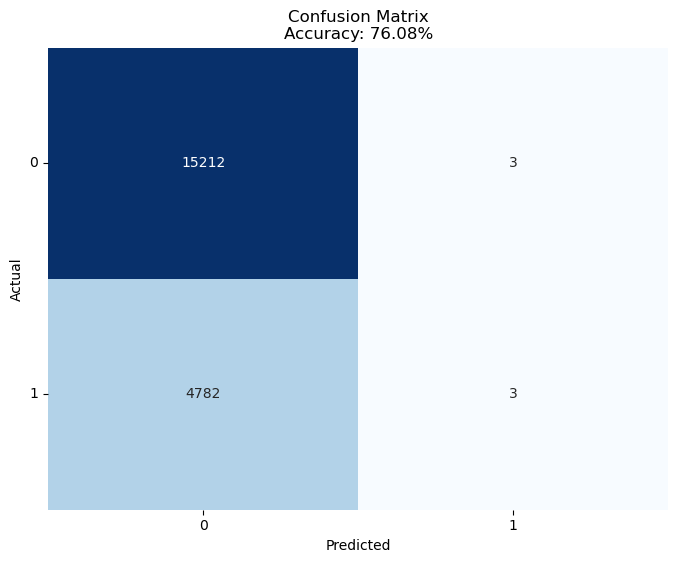

In [321]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(actual_values, predicted_values)

# Compute accuracy
accuracy = accuracy_score(actual_values, predicted_values)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)

# Add labels to the plot
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix\nAccuracy: {:.2f}%'.format(accuracy * 100))
plt.xticks([0.5, 1.5], ['0', '1'])
plt.yticks([0.5, 1.5], ['0', '1'], rotation=0)
plt.show()


In [111]:
session = sagemaker.Session()

# Fetch the model
model = sagemaker.model.Model(model_data="s3://sagemaker-us-east-1-057243345877/output/linear-learner-2023-10-28-12-43-19-093/output/model.tar.gz", 
                              role= role ,
                              image_uri=container,                                
                              sagemaker_session=session)

# Print the model details
print(model.__dict__)


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
{'model_data': 's3://sagemaker-us-east-1-057243345877/output/linear-learner-2023-10-28-12-43-19-093/output/model.tar.gz', 'image_uri': '382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1', 'predictor_cls': None, 'name': None, '_base_name': None, 'sagemaker_session': <sagemaker.session.Session object at 0x7f32a374ce50>, '_sagemaker_config': None, 'role': 'arn:aws:iam::057243345877:role/c94466a2114446l5119703t1w057-SageMakerExecutionRole-jg6VUMP3LOND', 'vpc_config': None, 'endpoint_name': None, '_is_compiled_model': False, '_compilation_job_name': None, '_is_edge_packaged_model': False, 'inference_recommender_job_results': None, 'inference_recommendations': None, '_enable_network_isolation': False, 'env': {}, 'model_kms_key': None, 'image_config': None, 'entry_point': None, 

In [329]:
ll_predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: linear-learner-1-28-13-17-32
INFO:sagemaker:Deleting endpoint with name: linear-learner-1-28-13-17-32


In [327]:
data2 = pd.read_csv('combined_csv_v2.csv')

In [328]:
# Step 1: Check for unique strings in object columns
object_cols = data2.select_dtypes(include=['object']).columns
unique_values = {col: data2[col].unique() for col in object_cols}
print(unique_values)  

# Step 2: Replace known boolean strings and anomalies
data2.replace({'True': 1.0, 'False': 0.0, 'Fals': 0.0}, inplace=True)

# Convert any remaining object columns to float64
data2[object_cols] = data2[object_cols].astype('float64')



data2.dropna(inplace=True)

#clean the data2
bool_cols = [col for col in data2.columns if data2[col].dtype == np.bool]
data2[bool_cols] = data2[bool_cols].astype('float64')


data2.head(2)



train_validation_data2, test_data2 = train_test_split(data2, test_size=0.15, random_state=14)

train_data2, validation_data2 = train_test_split(train_validation_data2, test_size=0.1765, random_state=14) # 0.1765 * 0.85 = 0.15

train_y2 = train_data2.iloc[:, 0].to_numpy()
train_X2 = train_data2.iloc[:, 1:].to_numpy()

validation_y2 = validation_data2.iloc[:, 0].to_numpy()
validation_X2 = validation_data2.iloc[:, 1:].to_numpy()

test_y2 = test_data2.iloc[:, 0].to_numpy()
test_X2 = test_data2.iloc[:, 1:].to_numpy()


print(train_data2.shape)
print(validation_data2.shape)


train_data2.to_csv('train_data2.csv', index=False, header=False)
validation_data2.to_csv('validation_data2.csv', index=False, header=False)
test_data2.to_csv('test_data2.csv', index=False, header=False)


s3_session = sagemaker.Session()
bucket = s3_session.default_bucket()
bucket



train_data2_s3_path = 'data2/train_data2.csv'
validation_data2_s3_path = 'data2/validation_data2.csv'
test_data2_s3_path = 'data2/test_data2.csv'

s3_client = boto3.client('s3')
s3_client.upload_file('train_data2.csv', bucket, train_data2_s3_path)
s3_client.upload_file('validation_data2.csv', bucket, validation_data2_s3_path)
s3_client.upload_file('test_data2.csv', bucket, test_data2_s3_path)

response = s3_client.list_objects(Bucket=bucket, Prefix='data2/')
for item in response.get('Contents', []):
    print(f's3://{bucket}/{item["Key"]}')



df_train1 = pd.read_csv('train_data2.csv')
df_validation1 = pd.read_csv('validation_data2.csv')
df_test1 = pd.read_csv('test_data2.csv')


if df_train1.isnull().any().any():
    print("df_train1 contains empty values.")
else:
    print("df_train1 does not contain any empty values.")

if df_validation1.isnull().any().any():
    print("df_validation1 contains empty values.")
else:
    print("df_validation1 does not contain any empty values.")
    
if df_test1.isnull().any().any():
    print("df_test1 contains empty values.")
else:
    print("df_test1 does not contain any empty values.")



role = get_execution_role()
region = boto3.Session().region_name
container = get_image_uri(region, 'linear-learner')

ll_estimator = Estimator(container,
    role=role, 
    train_instance_count=1,
    train_instance_type='ml.m5.2xlarge',
    output_path=f's3://{bucket}/output',
)
ll_estimator.set_hyperparameters(predictor_type='binary_classifier', mini_batch_size=100)




{}
(1144871, 83)
(245380, 83)
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
s3://sagemaker-us-east-1-057243345877/data2/test_data2.csv
s3://sagemaker-us-east-1-057243345877/data2/train_data2.csv
s3://sagemaker-us-east-1-057243345877/data2/validation_data2.csv
df_train1 does not contain any empty values.
df_validation1 does not contain any empty values.
df_test1 does not contain any empty values.
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [ ]:
s3_train_data = TrainingInput(s3_data=f's3://{bucket}/{train_data2_s3_path}', content_type='text/csv')
s3_validation_data = TrainingInput(s3_data=f's3://{bucket}/{validation_data2_s3_path}', content_type='text/csv')

data_channels = {
    'train': s3_train_data,
    'validation': s3_validation_data
}

ll_estimator.fit(data_channels, wait=True)




INFO:sagemaker:Creating training-job with name: linear-learner-2023-10-28-16-04-30-889


2023-10-28 16:04:31 Starting - Starting the training job...
2023-10-28 16:04:48 Starting - Preparing the instances for training......
2023-10-28 16:06:01 Downloading - Downloading input data...
2023-10-28 16:06:32 Training - Downloading the training image......
2023-10-28 16:07:17 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
[10/28/2023 16:07:42 INFO 140580818536256] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss': 

In [342]:
response = s3_client.list_objects_v2(Bucket=bucket, Prefix=ll_estimator.output_path.split('/')[-1])
for content in response.get('Contents', []):
    print(content['Key'])


timestamp = strftime('%d-%H-%M-%S', gmtime())
endpoint_name = 'linear-learner-2-' + timestamp


output/linear-learner-2023-10-28-12-27-19-157/debug-output/training_job_end.ts
output/linear-learner-2023-10-28-12-27-19-157/profiler-output/framework/training_job_end.ts
output/linear-learner-2023-10-28-12-27-19-157/profiler-output/system/incremental/2023102812/1698496080.algo-1.json
output/linear-learner-2023-10-28-12-27-19-157/profiler-output/system/incremental/2023102812/1698496140.algo-1.json
output/linear-learner-2023-10-28-12-27-19-157/profiler-output/system/incremental/2023102812/1698496200.algo-1.json
output/linear-learner-2023-10-28-12-27-19-157/profiler-output/system/training_job_end.ts
output/linear-learner-2023-10-28-12-43-19-093/debug-output/training_job_end.ts
output/linear-learner-2023-10-28-12-43-19-093/output/model.tar.gz
output/linear-learner-2023-10-28-12-43-19-093/profiler-output/framework/training_job_end.ts
output/linear-learner-2023-10-28-12-43-19-093/profiler-output/system/incremental/2023102812/1698497040.algo-1.json
output/linear-learner-2023-10-28-12-43-19-0

In [343]:
print(endpoint_name)

linear-learner-2-28-19-47-50


In [344]:
ll_predictor2 = ll_estimator.deploy(endpoint_name=endpoint_name, 
                        initial_instance_count=1, 
                        instance_type='ml.m5.2xlarge')

INFO:sagemaker:Creating model with name: linear-learner-2023-10-28-19-48-06-740
INFO:sagemaker:Creating endpoint-config with name linear-learner-2-28-19-47-50
INFO:sagemaker:Creating endpoint with name linear-learner-2-28-19-47-50


------!

In [345]:
df_test2 = pd.read_csv('test_data2.csv')

In [346]:
df_test2.columns

Index(['0.0', '1744.0', '12', '30', '0', '78.0', '35', '0.1', '183.0', '0.0.1',
       '0.0.2', '0.2', '1', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9',
       '0.10', '0.11', '0.12', '1.1', '0.13', '0.14', '0.15', '0.16', '0.17',
       '0.18', '0.19', '0.20', '0.21', '0.22', '0.23', '0.24', '0.25', '0.26',
       '0.27', '0.28', '0.29', '0.30', '0.31', '0.32', '0.33', '0.34', '0.35',
       '0.36', '0.37', '1.2', '0.38', '0.39', '0.40', '0.41', '0.42', '0.43',
       '1.3', '0.44', '0.45', '0.46', '0.47', '0.48', '0.49', '0.50', '0.51',
       '0.52', '0.53', '0.54', '0.55', '0.56', '0.57', '1.4', '0.58', '0.59',
       '0.60', '0.61', '0.62', '0.63', '1.5', '0.64', '0.65', '0.66', '0.67'],
      dtype='object')

In [347]:
actual_list = df_test2[df_test2.columns[0]].tolist()

In [348]:
df_test2.drop('0.0', axis=1, inplace=True)

In [349]:
# Configure the predictor
ll_predictor2.content_type = 'text/csv'
ll_predictor2.serializer = CSVSerializer()  # Note the parentheses to create an instance
ll_predictor2.deserializer = CSVDeserializer()

predictions = ll_predictor2.predict(df_test2.head(20000))

In [350]:
predicted_values = [float(pred[0]) for pred in predictions]
actual_values = actual_list[:20000]

accuracy = accuracy_score(actual_values, predicted_values)
precision = precision_score(actual_values, predicted_values)
recall = recall_score(actual_values, predicted_values)
f1 = f1_score(actual_values, predicted_values)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.7937
Precision: 0.5700575815738963
Recall: 0.07073112645868064
F1 Score: 0.12584745762711863


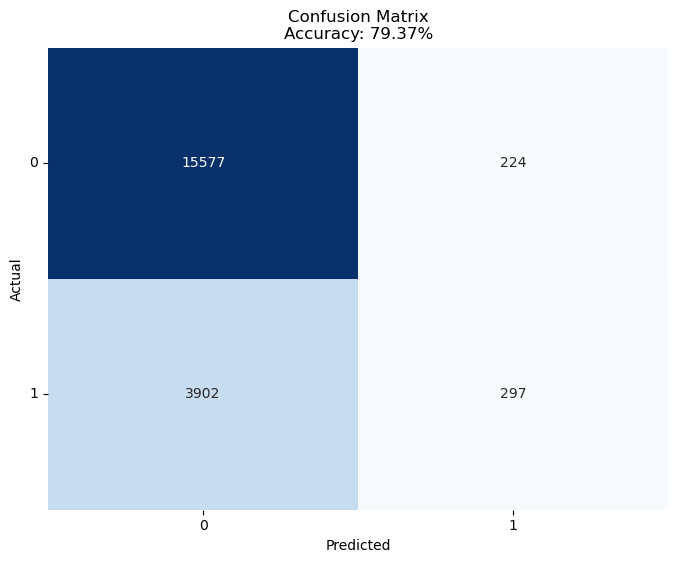

In [351]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(actual_values, predicted_values)

# Compute accuracy
accuracy = accuracy_score(actual_values, predicted_values)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)

# Add labels to the plot
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix\nAccuracy: {:.2f}%'.format(accuracy * 100))
plt.xticks([0.5, 1.5], ['0', '1'])
plt.yticks([0.5, 1.5], ['0', '1'], rotation=0)
plt.show()


In [352]:
ll_predictor2.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: linear-learner-2-28-19-47-50
INFO:sagemaker:Deleting endpoint with name: linear-learner-2-28-19-47-50


# Step 3: Build and evaluate ensembe models

Write code to perform the follwoing steps:
1. Split data into training, validation and testing sets (70% - 15% - 15%).
2. Use xgboost estimator to build a classifcation model.
3. Host the model on another instance
4. Perform batch transform to evaluate the model on testing data
5. Report the performance metrics that you see better test the model performance 
6. write down your observation on the difference between the performance of using the simple and ensemble models.
Note: You are required to perform the above steps on the two combined datasets separatey.

In [157]:
print(region)

us-east-1


In [181]:
container_pt2 = get_image_uri(region, 'xgboost', repo_version='1.0-1')

xgb_estimator = Estimator(container_pt2,
    role=role, 
    train_instance_count=1,
    train_instance_type='ml.m5.2xlarge',
    output_path=f's3://{bucket}/output',
)

xgb_estimator.set_hyperparameters(objective='reg:squarederror',
                                 num_round=200,
                                 early_stopping_rounds=10)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [182]:
xgb_estimator.fit(data_channels)

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-10-28-15-03-17-073


2023-10-28 15:03:17 Starting - Starting the training job...
2023-10-28 15:03:34 Starting - Preparing the instances for training......
2023-10-28 15:04:33 Downloading - Downloading input data...
2023-10-28 15:05:14 Training - Training image download completed. Training in progress....[2023-10-28 15:05:33.870 ip-10-0-145-200.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Single node training.
[15

In [200]:
response = s3_client.list_objects_v2(Bucket=bucket, Prefix=ll_estimator.output_path.split('/')[-1])
for content in response.get('Contents', []):
    print(content['Key'])

output/linear-learner-2023-10-28-12-27-19-157/debug-output/training_job_end.ts
output/linear-learner-2023-10-28-12-27-19-157/profiler-output/framework/training_job_end.ts
output/linear-learner-2023-10-28-12-27-19-157/profiler-output/system/incremental/2023102812/1698496080.algo-1.json
output/linear-learner-2023-10-28-12-27-19-157/profiler-output/system/incremental/2023102812/1698496140.algo-1.json
output/linear-learner-2023-10-28-12-27-19-157/profiler-output/system/incremental/2023102812/1698496200.algo-1.json
output/linear-learner-2023-10-28-12-27-19-157/profiler-output/system/training_job_end.ts
output/linear-learner-2023-10-28-12-43-19-093/debug-output/training_job_end.ts
output/linear-learner-2023-10-28-12-43-19-093/output/model.tar.gz
output/linear-learner-2023-10-28-12-43-19-093/profiler-output/framework/training_job_end.ts
output/linear-learner-2023-10-28-12-43-19-093/profiler-output/system/incremental/2023102812/1698497040.algo-1.json
output/linear-learner-2023-10-28-12-43-19-0

In [211]:
timestamp = strftime('%d-%H-%M-%S', gmtime())
endpoint_name = 'xgb-1-' + timestamp
print(endpoint_name)
xgb_predictor1 = xgb_estimator.deploy(endpoint_name=endpoint_name, 
                        initial_instance_count=1, 
                        instance_type='ml.m5.2xlarge')

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-10-28-15-21-47-414


xgb-1-28-15-21-47


INFO:sagemaker:Creating endpoint-config with name xgb-1-28-15-21-47
INFO:sagemaker:Creating endpoint with name xgb-1-28-15-21-47


----!

In [323]:
xgb_predictor1.content_type = 'text/csv'
xgb_predictor1.serializer = CSVSerializer()
xgb_predictor1.deserializer = CSVDeserializer()

predictions = xgb_predictor1.predict(df_test1.head(20000))


#### Flatten the predictions as it is probability


In [324]:
flattened_predictions = [float(val) for sublist in predictions for val in sublist]

# Convert the probability scores to class labels using a threshold of 0.5
predicted_labels = [1.0 if pred > 0.5 else 0.0 for pred in flattened_predictions]


In [325]:
predicted_values = predicted_labels
actual_values = actual_list[:20000]

accuracy = accuracy_score(actual_values, predicted_values)
precision = precision_score(actual_values, predicted_values)
recall = recall_score(actual_values, predicted_values)
f1 = f1_score(actual_values, predicted_values)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.7961
Precision: 0.7046902142443544
Recall: 0.25433646812957156
F1 Score: 0.37377149877149873


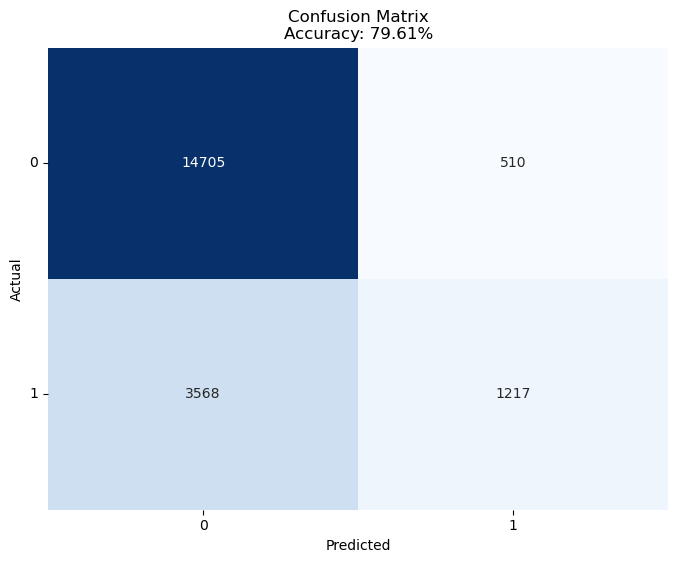

In [326]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(actual_values, predicted_values)

# Compute accuracy
accuracy = accuracy_score(actual_values, predicted_values)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)

# Add labels to the plot
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix\nAccuracy: {:.2f}%'.format(accuracy * 100))
plt.xticks([0.5, 1.5], ['0', '1'])
plt.yticks([0.5, 1.5], ['0', '1'], rotation=0)
plt.show()


In [ ]:
xgb_predictor1.delete_endpoint()

In [354]:
#now the data channels loaded with the combined_csv_v2, in previous step, fit the model on dataset 2
s3_train_data = TrainingInput(s3_data=f's3://{bucket}/{train_data2_s3_path}', content_type='text/csv')
s3_validation_data = TrainingInput(s3_data=f's3://{bucket}/{validation_data2_s3_path}', content_type='text/csv')

data_channels2 = {
    'train': s3_train_data,
    'validation': s3_validation_data
}

xgb_estimator.fit(data_channels2)

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-10-28-19-53-14-391


2023-10-28 19:53:14 Starting - Starting the training job...
2023-10-28 19:53:31 Starting - Preparing the instances for training......
2023-10-28 19:54:29 Downloading - Downloading input data......
2023-10-28 19:55:29 Training - Downloading the training image...
2023-10-28 19:56:01 Training - Training image download completed. Training in progress..[2023-10-28 19:56:03.297 ip-10-0-232-203.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined

In [355]:
response = s3_client.list_objects_v2(Bucket=bucket, Prefix=ll_estimator.output_path.split('/')[-1])
for content in response.get('Contents', []):
    print(content['Key'])

output/linear-learner-2023-10-28-12-27-19-157/debug-output/training_job_end.ts
output/linear-learner-2023-10-28-12-27-19-157/profiler-output/framework/training_job_end.ts
output/linear-learner-2023-10-28-12-27-19-157/profiler-output/system/incremental/2023102812/1698496080.algo-1.json
output/linear-learner-2023-10-28-12-27-19-157/profiler-output/system/incremental/2023102812/1698496140.algo-1.json
output/linear-learner-2023-10-28-12-27-19-157/profiler-output/system/incremental/2023102812/1698496200.algo-1.json
output/linear-learner-2023-10-28-12-27-19-157/profiler-output/system/training_job_end.ts
output/linear-learner-2023-10-28-12-43-19-093/debug-output/training_job_end.ts
output/linear-learner-2023-10-28-12-43-19-093/output/model.tar.gz
output/linear-learner-2023-10-28-12-43-19-093/profiler-output/framework/training_job_end.ts
output/linear-learner-2023-10-28-12-43-19-093/profiler-output/system/incremental/2023102812/1698497040.algo-1.json
output/linear-learner-2023-10-28-12-43-19-0

In [356]:
timestamp = strftime('%d-%H-%M-%S', gmtime())
endpoint_name = 'xgb-2-' + timestamp
print(endpoint_name)
xgb_predictor2 = xgb_estimator.deploy(endpoint_name=endpoint_name, 
                        initial_instance_count=1, 
                        instance_type='ml.m5.2xlarge')

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-10-28-20-08-01-891


xgb-2-28-20-08-01


INFO:sagemaker:Creating endpoint-config with name xgb-2-28-20-08-01
INFO:sagemaker:Creating endpoint with name xgb-2-28-20-08-01


----!

In [357]:
xgb_predictor2.content_type = 'text/csv'
xgb_predictor2.serializer = CSVSerializer()
xgb_predictor2.deserializer = CSVDeserializer()

predictions = xgb_predictor2.predict(df_test2.head(20000))


In [358]:
flattened_predictions = [float(val) for sublist in predictions for val in sublist]

# Convert the probability scores to class labels using a threshold of 0.5
predicted_labels = [1.0 if pred > 0.5 else 0.0 for pred in flattened_predictions]


In [359]:
predicted_values = predicted_labels
actual_values = actual_list[:20000]

accuracy = accuracy_score(actual_values, predicted_values)
precision = precision_score(actual_values, predicted_values)
recall = recall_score(actual_values, predicted_values)
f1 = f1_score(actual_values, predicted_values)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.8128
Precision: 0.712022367194781
Recall: 0.18194808287687544
F1 Score: 0.28983308042488615


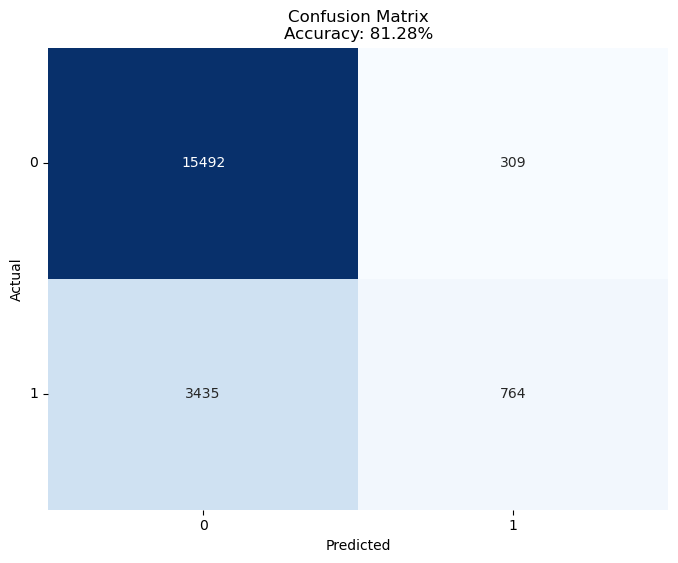

In [360]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

# Assuming you've already processed your predictions into predicted_labels
# and your actual values are in a list named actual

# Calculate the confusion matrix
cm = confusion_matrix(actual_values, predicted_values)

# Compute accuracy
accuracy = accuracy_score(actual_values, predicted_values)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)

# Add labels to the plot
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix\nAccuracy: {:.2f}%'.format(accuracy * 100))
plt.xticks([0.5, 1.5], ['0', '1'])
plt.yticks([0.5, 1.5], ['0', '1'], rotation=0)
plt.show()


#### Conclusion

In my final project titled "oncloudproject", I experimented with both linear models and XGBoost to predict flight delays. While the linear model took considerably longer to train compared to XGBoost, its accuracy was also notably lower. Specifically, the linear model required anywhere from 20 minutes to 2 hours to train, while XGBoost finished in a swift 3 to 6 minutes.  

Performance-wise, XGBoost consistently outdid the linear model across different datasets:  
- Without incorporating weather information, the linear model achieved an accuracy of **76.08%**. In contrast, XGBoost managed a higher **79.61%** on the same dataset.
- When weather information was included, the linear model's accuracy rose to **79.37%**. However, XGBoost still led with an accuracy of **81.28%**.  

While linear models are typically suited for scenarios where there's an approximate linear relationship between input and output, they might not be the best choice when the data has complex patterns or non-linear relationships. On the other hand, XGBoost is a sophisticated gradient boosting algorithm capable of identifying these complex patterns, making it a valuable tool not just for regression but also for classification tasks.  


While AWS SageMaker offers a lot of potential, my journey with it wasn't without challenges. A primary concern was the constraints related to instance availability, particularly the 8-hour limit on my SageMaker instance(Sandbox). Several times, my notebook was terminated while I was actively working on it. Other challenges included the time taken to build models, and issues concerning size, permissions, and access. The limited access to logs also made troubleshooting challenging. Additionally, data formatting proved to be a significant roadblock.  

To conclude, the potential of cloud-based machine learning is undeniable and offers numerous advantages. Among the tools explored, XGBoost stood out as a powerful and efficient algorithm, consistently outperforming the linear model in accuracy and training time. With ongoing refinement, the cloud-based machine learning's capabilities will expand further.

